reference: https://www.kaggle.com/code/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition

In [1]:
!gdown --id 1O3ZunZfkUG3foSIbehe896HlwoY88lG-

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1O3ZunZfkUG3foSIbehe896HlwoY88lG-
To: /content/Housing.csv
100% 964k/964k [00:00<00:00, 28.5MB/s]


In [2]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np


# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor




In [4]:
# Load CSV and columns
df = pd.read_csv("Housing.csv")
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


# Split data

In [5]:
train, test= train_test_split(df, test_size=0.2, random_state=42)

# SalePrice: the variable we're trying to predict

<ipython-input-6-0e25d499c935>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['SalePrice'], color="b");


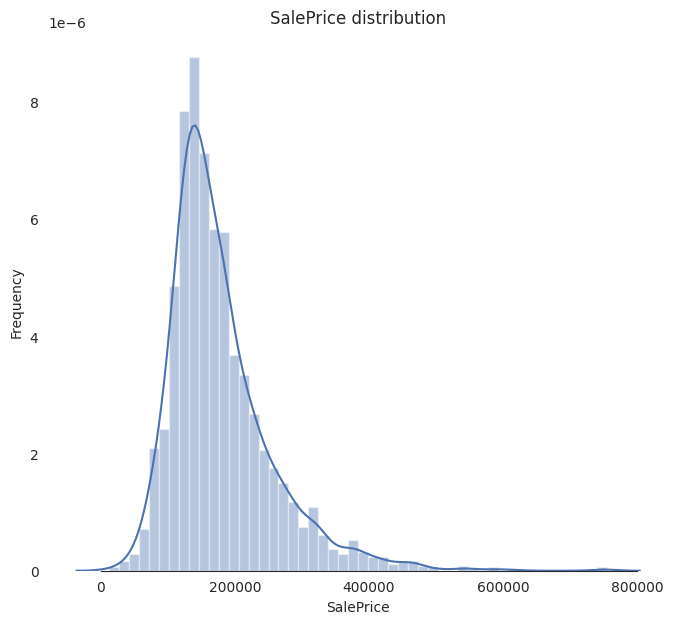

In [6]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution
sns.distplot(train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

In [7]:
# Skew and kurt
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.750597
Kurtosis: 5.474455


# Features: a deep dive

In [10]:
# Finding numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in train.columns:
    if train[i].dtype in numeric_dtypes:
        numeric.append(i)

print(len(numeric))
print(numeric)

39
['Order', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'SalePrice']


In [11]:
# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)

for i, feature in enumerate(list(train[numeric]), 1):
    if(feature=='Misc Val'):
        break

    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=train)

    plt.xlabel('{}'.format(feature), size=15, labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)

    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)

    plt.legend(loc='best', prop={'size': 10})

plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Correlation matrix

<ipython-input-12-5f7257d8d405>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corr()


<Axes: >

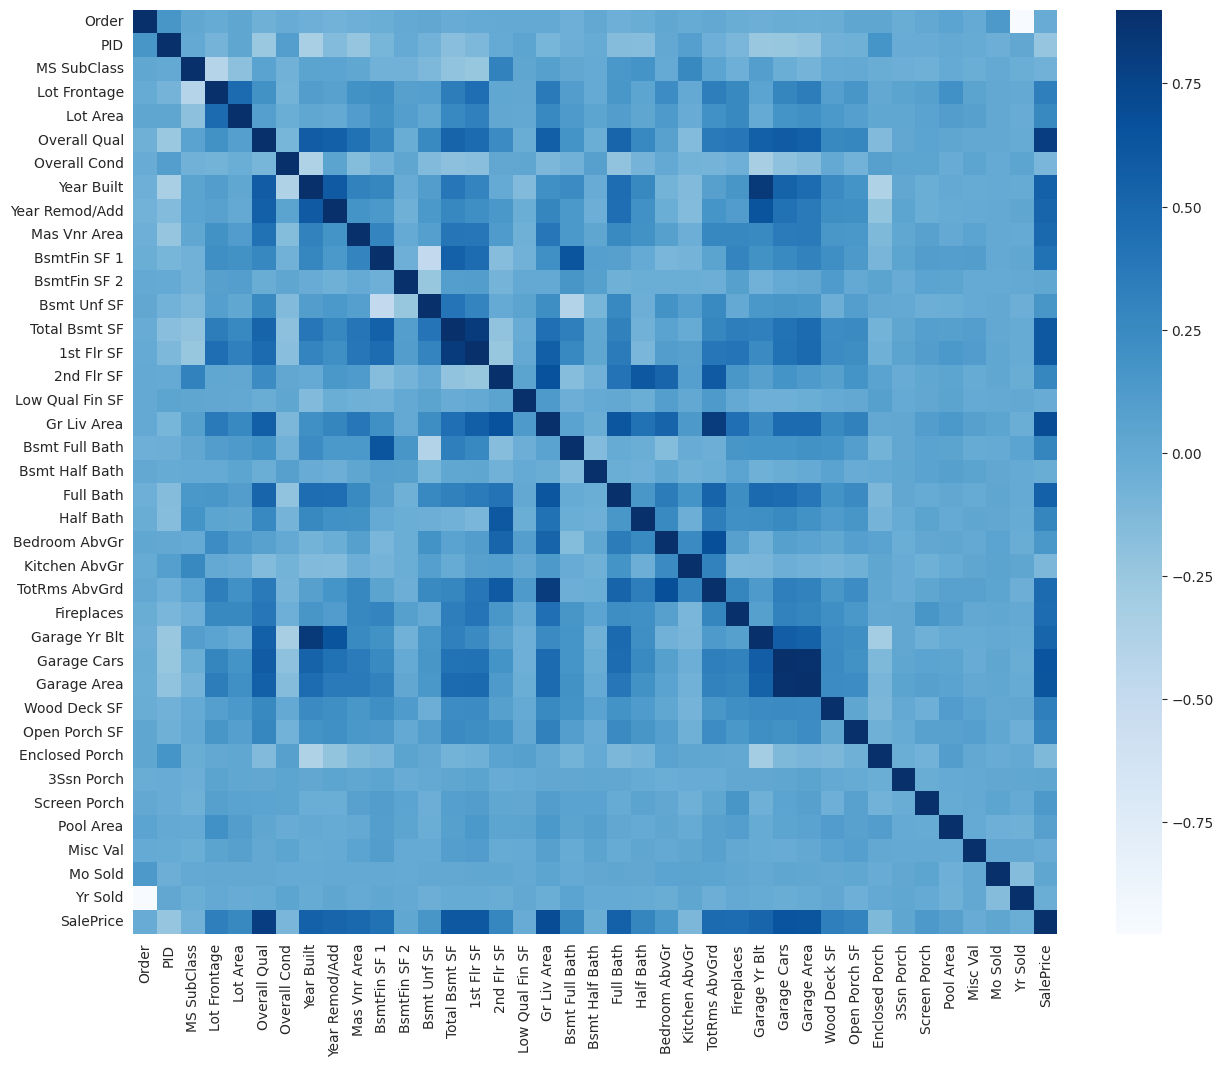

In [12]:
corr = train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)


#Drop id column

In [6]:
train_ID = train['PID']
test_ID = test['PID']
train.drop(['PID'], axis=1, inplace=True)
test.drop(['PID'], axis=1, inplace=True)

train.drop(['Order'], axis=1, inplace=True)
test.drop(['Order'], axis=1, inplace=True)
train.shape, test.shape

((2344, 80), (586, 80))

# Remove outliers

In [7]:
# Remove outliers
train.drop(train[(train['Overall Qual'] == 4) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['Overall Qual'] == 6) & (train['SalePrice']>300000)].index, inplace=True)
train.drop(train[(train['Gr Liv Area'] > 4500) & (train['SalePrice']<300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

# Feature Engineering

<ipython-input-14-d0d17daf5ecd>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['SalePrice'], color="b");


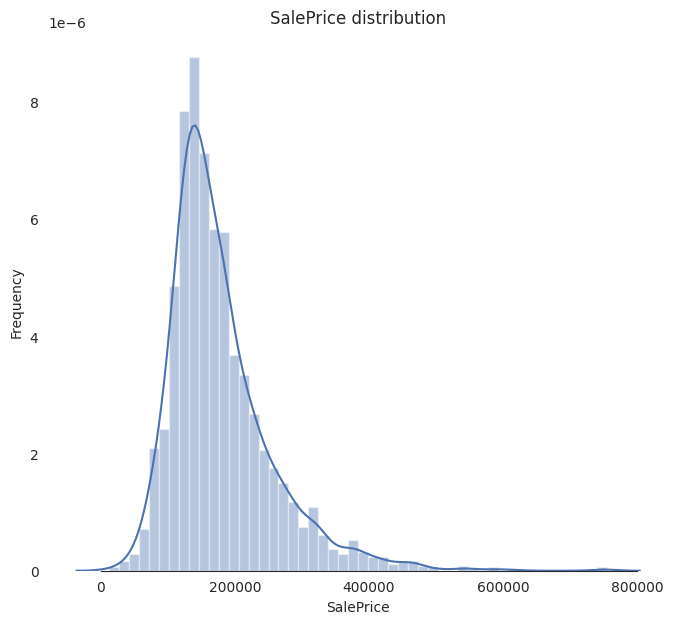

In [14]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))

#Check the new distribution
sns.distplot(train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

In [8]:
# log(1+x) transform
train["SalePrice"] = np.log1p(train["SalePrice"])

<ipython-input-17-d51b36b5db5d>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['SalePrice'] , fit=norm, color="b");



 mu = 12.01 and sigma = 0.40



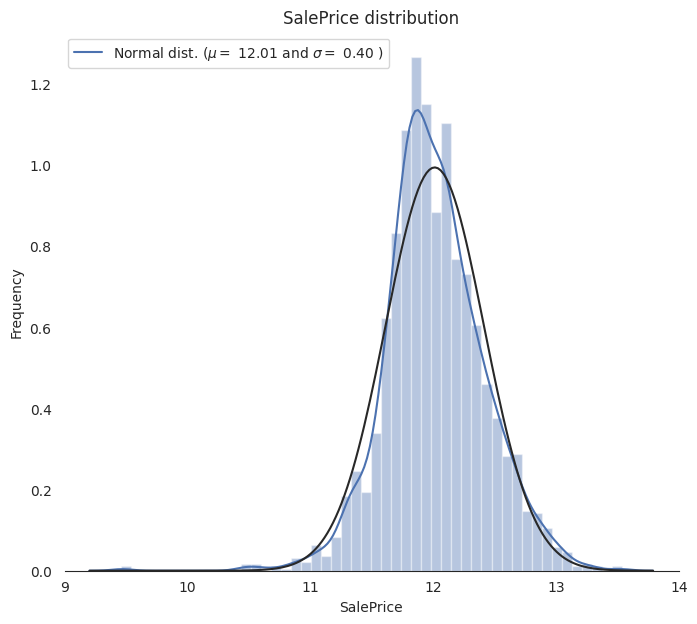

In [17]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution
sns.distplot(train['SalePrice'] , fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

# Merge data to handle

In [9]:
# train data
train_labels = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)

# test data
test_labels = test['SalePrice'].reset_index(drop=True)
test_features = test.drop(['SalePrice'], axis=1)


# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(2926, 79)

# Fill missing values

In [10]:
# determine the threshold for missing values
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    return dict_x

missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
print(df_miss)

Percent of missing data
[('Pool QC', 99.59), ('Misc Feature', 96.41), ('Alley', 93.23), ('Fence', 80.45), ('Fireplace Qu', 48.6), ('Lot Frontage', 16.71), ('Garage Yr Blt', 5.43), ('Garage Finish', 5.43), ('Garage Qual', 5.43), ('Garage Cond', 5.43), ('Garage Type', 5.37), ('Bsmt Exposure', 2.84), ('BsmtFin Type 2', 2.77), ('Bsmt Qual', 2.73), ('Bsmt Cond', 2.73), ('BsmtFin Type 1', 2.73), ('Mas Vnr Type', 0.79), ('Mas Vnr Area', 0.79), ('Bsmt Full Bath', 0.07), ('Bsmt Half Bath', 0.07), ('BsmtFin SF 1', 0.03), ('BsmtFin SF 2', 0.03), ('Bsmt Unf SF', 0.03), ('Total Bsmt SF', 0.03), ('Electrical', 0.03), ('Garage Cars', 0.03), ('Garage Area', 0.03), ('MS SubClass', 0.0), ('MS Zoning', 0.0), ('Lot Area', 0.0), ('Street', 0.0), ('Lot Shape', 0.0), ('Land Contour', 0.0), ('Utilities', 0.0), ('Lot Config', 0.0), ('Land Slope', 0.0), ('Neighborhood', 0.0), ('Condition 1', 0.0), ('Condition 2', 0.0), ('Bldg Type', 0.0), ('House Style', 0.0), ('Overall Qual', 0.0), ('Overall Cond', 0.0), ('Yea

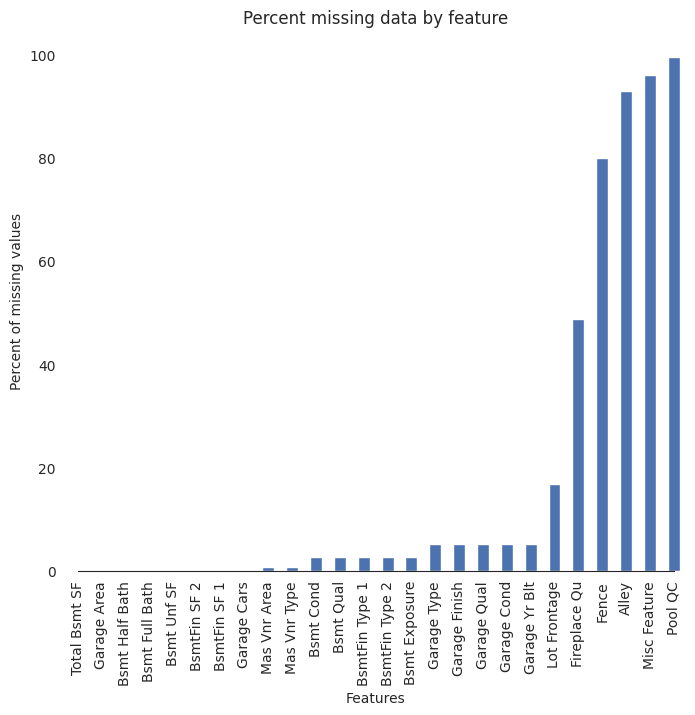

In [21]:
# Visualize missing values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')

missing = round(train.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="b")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

In [11]:
# Some of the non-numeric predictors are stored as numbers; convert them into strings
all_features['MS SubClass'] = all_features['MS SubClass'].apply(str)
all_features['Yr Sold'] = all_features['Yr Sold'].astype(str)
all_features['Mo Sold'] = all_features['Mo Sold'].astype(str)

In [12]:
def handle_missing(features):
    # Replace the missing values in each of the columns below with their mode
    features['Electrical'] = features['Electrical'].fillna("SBrkr")

    # the data description stats that NA refers to "No Pool"
    features["Pool QC"] = features["Pool QC"].fillna("NA")

    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ('Garage Yr Blt', 'Garage Area', 'Garage Cars'):
        features[col] = features[col].fillna(0)

    # Replacing the missing values with NA
    for col in ['Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2']:
        features[col] = features[col].fillna('NA')

    # Replacing the missing values with None
    for col in ['Mas Vnr Type']:
        features[col] = features[col].fillna('None')

    # Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
    features['Lot Frontage'] = features.groupby('Neighborhood')['Lot Frontage'].transform(lambda x: x.fillna(x.median()))

    # We have no particular intuition around how to fill in the rest of the categorical features
    # So we replace their missing values with None
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('NA'))

    # And we do the same thing for numerical features, but this time with 0s
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))
    return features

all_features = handle_missing(all_features)

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [13]:
# Let's make sure we handled all the missing values
missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('MS SubClass', 0.0),
 ('MS Zoning', 0.0),
 ('Lot Frontage', 0.0),
 ('Lot Area', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('Lot Shape', 0.0),
 ('Land Contour', 0.0),
 ('Utilities', 0.0),
 ('Lot Config', 0.0)]

# Fix skewed features

In [14]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)


In [31]:
print(len(numeric))

33


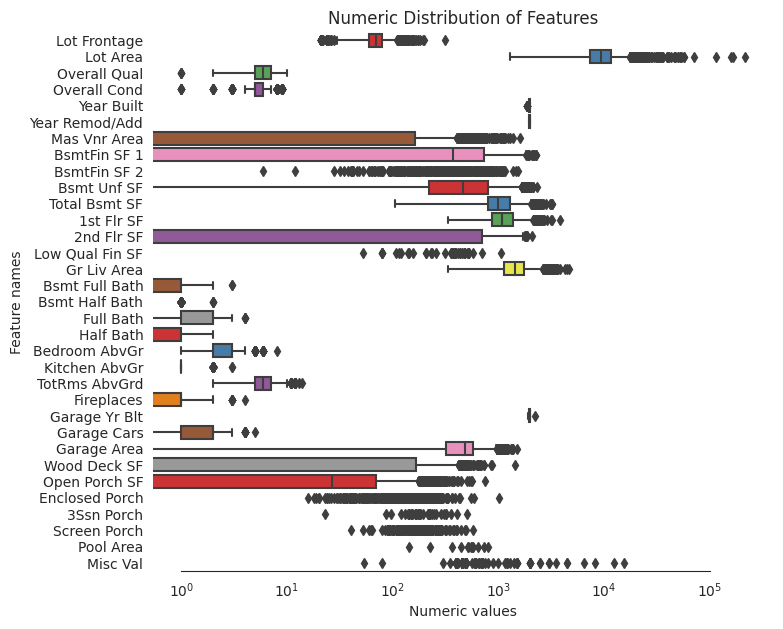

In [29]:
# Create box plots for all numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [15]:
# Find skewed numerical features
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
print(skew_features)

There are 24 numerical features with Skew > 0.5 :
Misc Val           22.217407
Pool Area          17.716191
Lot Area           13.258348
Low Qual Fin SF    12.103527
3Ssn Porch         11.390000
Kitchen AbvGr       4.308214
BsmtFin SF 2        4.135410
Enclosed Porch      4.009571
Screen Porch        3.952262
Bsmt Half Bath      3.951698
Mas Vnr Area        2.593672
Open Porch SF       2.507768
Wood Deck SF        1.834040
Lot Frontage        1.056263
Gr Liv Area         1.025237
1st Flr SF          0.983490
Bsmt Unf SF         0.923976
2nd Flr SF          0.860359
BsmtFin SF 1        0.844191
Fireplaces          0.731357
TotRms AbvGrd       0.707051
Half Bath           0.699960
Bsmt Full Bath      0.615384
Overall Cond        0.573431
Total Bsmt SF       0.439504
Bedroom AbvGr       0.302226
Garage Area         0.211489
Overall Qual        0.182752
Full Bath           0.169826
Garage Cars        -0.220107
Year Remod/Add     -0.449989
Year Built         -0.605094
Garage Yr Blt      -3.

In [16]:
# Normalize skewed features
for i in skew_index:
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


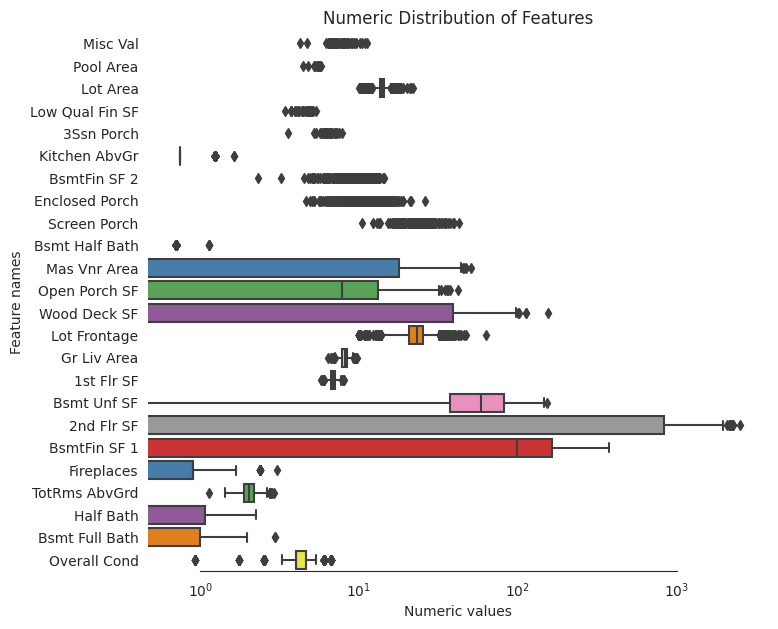

In [34]:
# Let's make sure we handled all the skewed values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[skew_index] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

#Create interesting features

In [17]:
all_features['BsmtFinType1_Unf'] = 1*(all_features['BsmtFin Type 1'] == 'Unf')
all_features['HasWoodDeck'] = (all_features['Wood Deck SF'] == 0) * 1
all_features['HasOpenPorch'] = (all_features['Open Porch SF'] == 0) * 1
all_features['HasEnclosedPorch'] = (all_features['Enclosed Porch'] == 0) * 1
all_features['Has3SsnPorch'] = (all_features['3Ssn Porch'] == 0) * 1
all_features['HasScreenPorch'] = (all_features['Screen Porch'] == 0) * 1
all_features['YearsSinceRemodel'] = all_features['Yr Sold'].astype(int) - all_features['Year Remod/Add'].astype(int)
all_features['Total_Home_Quality'] = all_features['Overall Qual'] + all_features['Overall Cond']

# remove the columns
all_features = all_features.drop(['Utilities', 'Street', 'Pool QC',], axis=1)

all_features['TotalSF'] = all_features['Total Bsmt SF'] + all_features['1st Flr SF'] + all_features['2nd Flr SF']
all_features['YrBltAndRemod'] = all_features['Year Built'] + all_features['Year Remod/Add']
all_features['Total_sqr_footage'] = (all_features['BsmtFin SF 1'] + all_features['BsmtFin SF 2'] + all_features['1st Flr SF'] + all_features['2nd Flr SF'])
all_features['Total_Bathrooms'] = (all_features['Full Bath'] + (0.5 * all_features['Half Bath']) + all_features['Bsmt Full Bath'] + (0.5 * all_features['Bsmt Half Bath']))
all_features['Total_porch_sf'] = (all_features['Open Porch SF'] + all_features['3Ssn Porch'] + all_features['Enclosed Porch'] + all_features['Screen Porch'] +  all_features['Wood Deck SF'])

all_features['TotalBsmtSF'] = all_features['Total Bsmt SF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['2ndFlrSF'] = all_features['2nd Flr SF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
all_features['GarageArea'] = all_features['Garage Area'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['GarageCars'] = all_features['Garage Cars'].apply(lambda x: 0 if x <= 0.0 else x)
all_features['LotFrontage'] = all_features['Lot Frontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
all_features['MasVnrArea'] = all_features['Mas Vnr Area'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
all_features['BsmtFinSF1'] = all_features['BsmtFin SF 1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

all_features['haspool'] = all_features['Pool Area'].apply(lambda x: 1 if x > 0 else 0)
all_features['has2ndfloor'] = all_features['2nd Flr SF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasgarage'] = all_features['Garage Area'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasbsmt'] = all_features['Total Bsmt SF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [39]:
all_features.shape

(2928, 101)

# Feature transformations

In [18]:
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01 + res[l])).values)
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['Lot Frontage','Lot Area','Mas Vnr Area','BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF',
                'Total Bsmt SF','1st Flr SF','2nd Flr SF','Low Qual Fin SF','Gr Liv Area', 'Bsmt Full Bath',
                'Bsmt Half Bath','Full Bath','Half Bath','Bedroom AbvGr','Kitchen AbvGr', 'TotRms AbvGrd',
                'Fireplaces','Garage Cars','Garage Area','Wood Deck SF','Open Porch SF', 'Enclosed Porch',
                '3Ssn Porch','Screen Porch','Pool Area','Misc Val','Year Remod/Add','TotalSF']

all_features = logs(all_features, log_features)

In [41]:
all_features.shape

(2928, 131)

In [19]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)
        res.columns.values[m] = l + '_sq'
        m += 1
    return res

squared_features = ['Year Remod/Add', 'Lot Frontage_log', 'Total Bsmt SF_log', '1st Flr SF_log', '2nd Flr SF_log',
                    'Gr Liv Area_log', 'Garage Cars_log', 'Garage Area_log']
all_features = squares(all_features, squared_features)

In [43]:
all_features.shape

(2928, 139)

In [20]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features.shape

(2926, 399)

In [ ]:
all_features.head()

,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,...,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,19.124936,13.348600,7,4.670467,1940,1950,0.000000,61.218150,0.0,73.661268,...,0,0,0,1,0,0,0,0,1,0
1,14.229964,13.684383,7,4.670467,2003,2003,20.718953,97.676973,0.0,58.554621,...,0,0,0,1,0,0,0,0,1,0
2,20.801352,14.244150,7,5.336870,1980,1991,20.976740,113.700834,0.0,57.249781,...,0,0,0,1,0,0,0,0,1,0
3,18.250279,13.996967,5,3.984526,1956,1956,0.000000,98.373840,0.0,62.933132,...,0,0,0,1,0,0,0,0,1,0
4,18.250279,13.351948,7,3.984526,2003,2003,21.930363,106.835745,0.0,48.493545,...,0,0,0,1,0,0,0,0,1,0


In [21]:
# Remove any duplicated column names
all_features = all_features.loc[:,~all_features.columns.duplicated()]

In [46]:
all_features.shape

(2928, 399)

# Recreate training and test sets

In [22]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
X.shape, train_labels.shape, X_test.shape

((2340, 399), (2340,), (586, 399))

In [24]:
# Finding numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in X.columns:
    if X[i].dtype in numeric_dtypes:
        if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
            pass
        else:
            numeric.append(i)

In [49]:
# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, figsize=(12, 150))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(X[numeric]), 1):
    if(feature=='Misc Val'):
        break
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=train)

    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)

    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)

    plt.legend(loc='best', prop={'size': 10})

plt.show()

Output hidden; open in https://colab.research.google.com to view.

#Setup cross validation and define error metrics

In [23]:
# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [24]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression',
                       num_leaves=6,
                       learning_rate=0.01,
                       n_estimators=7000,
                       max_bin=200,
                       bagging_fraction=0.8,
                       bagging_freq=4,
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

In [25]:
# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

In [26]:
# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

In [27]:
# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

In [28]:
# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)


In [29]:
# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

In [30]:
# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

# Train models

In [31]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

#Scoring

In [35]:
# Get cross validation scores for each model
scores = {}

In [36]:
score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))

scores['lgb'] = (score.mean(), score.std())

lightgbm: 0.1176 (0.0199)


In [60]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))

scores['xgb'] = (score.mean(), score.std())

[03:24:19] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[03:26:22] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[03:28:22] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[03:30:33] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[03:32:36] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[03:34:37] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[03:36:40] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[03:38:49] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[03:40:56] WARNING: ../src/objective/regression_

In [37]:
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))

scores['svr'] = (score.mean(), score.std())

SVR: 0.1164 (0.0228)


In [38]:
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))

scores['ridge'] = (score.mean(), score.std())

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.22274e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.88769e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.35768e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.48479e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarnin

ridge: 0.1140 (0.0199)


In [39]:
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))

scores['rf'] = (score.mean(), score.std())

rf: 0.1382 (0.0252)


In [40]:
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))

scores['gbr'] = (score.mean(), score.std())

gbr: 0.1155 (0.0237)


#Fit the models


In [32]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(train_labels))

stack_gen
[06:22:07] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[06:23:22] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[06:24:34] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[06:25:46] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[06:27:00] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.59012e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.00537e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.00114e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.8742e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning

[06:36:43] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[06:38:18] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.78785e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.7565e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.52853e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.33226e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning

In [33]:
print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, train_labels)

lightgbm


In [34]:
print('xgboost')
xgb_model_full_data = xgboost.fit(X, train_labels)

xgboost
[06:41:58] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [35]:
print('Svr')
svr_model_full_data = svr.fit(X, train_labels)

Svr


In [36]:
print('Ridge')
ridge_model_full_data = ridge.fit(X, train_labels)

Ridge


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.78785e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.7565e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.52853e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.33226e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning

In [37]:
print('RandomForest')
rf_model_full_data = rf.fit(X, train_labels)

RandomForest


In [38]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, train_labels)

GradientBoosting


# Blend models and get predictions

In [39]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    return ((0.15 * ridge_model_full_data.predict(X)) + \
            (0.15 * svr_model_full_data.predict(X)) + \
            (0.2 * gbr_model_full_data.predict(X)) + \
            (0.05 * xgb_model_full_data.predict(X)) + \
            (0.05 * lgb_model_full_data.predict(X)) + \
            (0.05 * rf_model_full_data.predict(X)) + \
            (0.35 * stack_gen_model.predict(np.array(X))))

In [40]:
def metric_result(y, y_pred):
  mae = mean_absolute_error(y, y_pred)
  mse = mean_squared_error(y, y_pred)
  rmse = mean_squared_error(y, y_pred, squared=False)
  r2 = r2_score(y, y_pred)

  print("mae: ", mae)
  print("mse: ", mse)
  print("rmse: ", rmse)
  print("r2_score:", r2)

In [41]:
# Get final precitions from the blended model
blended_score = rmsle(train_labels, blended_predictions(X))
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.08010228632075599


In [42]:
# train["SalePrice"] = np.log1p(train["SalePrice"])
predict = np.floor(np.expm1(blended_predictions(X_test)))

In [43]:
# Get final precitions from the blended model
blended_test_score = rmsle(test_labels, predict)
print('RMSLE score on train data:')
print(blended_test_score)

RMSLE score on train data:
26663.457483819828


In [44]:
metric_result(test_labels, predict)

mae:  12736.04266211604
mse:  710939964.9914676
rmse:  26663.457483819828
r2_score: 0.9113270078185896


# Fix outleir predictions

In [45]:
columns = ['SalePrice']
# Append predictions from blended models
submission = pd.DataFrame(data=predict, columns=columns)

In [46]:
# Fix outleir predictions
q1 = submission['SalePrice'].quantile(0.0045)
q2 = submission['SalePrice'].quantile(0.99)

print(q1)
print(q2)

56994.895
457837.45


In [47]:
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)

In [48]:
# Scale predictions
submission['SalePrice'] *= 1.001619

In [49]:
predict2 = submission['SalePrice'].values

In [50]:
metric_result(test_labels, predict2)

mae:  12444.773897339042
mse:  743238366.3069853
rmse:  27262.398396087334
r2_score: 0.9072985440546241
